We'll work with a dataset on sold houses in Ames, Iowa. Each row in the dataset describes the properties of a single house as well as the amount it was sold for. In this course, we'll build models that predict the final sale price from its other attributes. Specifically, we'll explore the following questions:

* Which properties of a house most affect the final sale price?
* How effectively can we predict the sale price from just its properties?

Here are some of the columns:

 * Lot Area: Lot size in square feet.
 * Overall Qual: Rates the overall material and finish of the house.
 * Overall Cond: Rates the overall condition of the house.
 * Year Built: Original construction date.
 * Low Qual Fin SF: Low quality finished square feet (all floors).
 * Full Bath: Full bathrooms above grade.
 * Fireplaces: Number of fireplaces.
 * Let's start by generating train and test datasets and getting more familiar with the data.

In [1]:
import pandas as pd
df = pd.read_csv('AmesHousing.txt', delimiter='\t')

In [2]:
train = df[:1460]
test = df[1460:]

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Order              1460 non-null int64
PID                1460 non-null int64
MS SubClass        1460 non-null int64
MS Zoning          1460 non-null object
Lot Frontage       1211 non-null float64
Lot Area           1460 non-null int64
Street             1460 non-null object
Alley              109 non-null object
Lot Shape          1460 non-null object
Land Contour       1460 non-null object
Utilities          1460 non-null object
Lot Config         1460 non-null object
Land Slope         1460 non-null object
Neighborhood       1460 non-null object
Condition 1        1460 non-null object
Condition 2        1460 non-null object
Bldg Type          1460 non-null object
House Style        1460 non-null object
Overall Qual       1460 non-null int64
Overall Cond       1460 non-null int64
Year Built         1460 non-null int64
Year Remod/Add     1460 non-null int64
Roof Style         14

In [3]:
target = 'SalePrice'

In [4]:
import matplotlib.pyplot as plt
# For prettier plots.
import seaborn as sns
sns.set()

plt.figure(figsize=(7,15))

plt.subplot(311)
plt.scatter(x="Garage Area", y="SalePrice", data=train)
plt.subplot(312)
plt.scatter(x="Gr Liv Area", y="SalePrice", data=train)
plt.subplot(313)
plt.scatter(x="Overall Cond", y="SalePrice", data=train)

plt.show()

<Figure size 700x1500 with 3 Axes>

From the last screen, we can tell that the `Gr Liv Area` feature correlates the most with the `SalePrice` column. We can confirm this by calculating the correlation between pairs of these columns using the `pandas.DataFrame.corr()` method:

In [5]:
print(train[['Garage Area', 'Gr Liv Area', 'Overall Cond', 'SalePrice']].corr())

              Garage Area  Gr Liv Area  Overall Cond  SalePrice
Garage Area      1.000000     0.465366     -0.132401   0.662397
Gr Liv Area      0.465366     1.000000     -0.133710   0.698990
Overall Cond    -0.132401    -0.133710      1.000000  -0.099395
SalePrice        0.662397     0.698990     -0.099395   1.000000


The correlation between `Gr Liv Area` and `SalePrice` is around 0.709, which is the highest. 

Let's now move on to understanding the model fitting criteria.

**Residual Sum Of Squares**

To find the optimal parameters for a linear regression model, we want to optimize the model's residual sum of squares (or RSS). If you recall, residual describes the difference between the predicted values for the target column and the true values. 

Let's now use scikit-learn to find the optimal parameter values for our model.  The `LinearRegression` class also has it's own `fit()` method. Specific to this model, however, are the `coef_` and `intercept_` attributes, which return a (or a(s) if it were a multivariate regression model) and b accordingly.

In [6]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(train[['Gr Liv Area']], train['SalePrice'])
print(lr.coef_)
print(lr.intercept_)

[116.86624683]
5366.821710056043


In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

train_preds = lr.predict(train[['Gr Liv Area']])
test_preds = lr.predict(test[['Gr Liv Area']])

train_mse = mean_squared_error(train['SalePrice'], train_preds)
test_mse = mean_squared_error(test['SalePrice'], test_preds)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

56034.362001412796
57088.25161263909


**Multivariate Linear Regression**

In [8]:
cols = ['Overall Cond', 'Gr Liv Area']

lr.fit(train[cols], train['SalePrice'])

train_preds = lr.predict(train[cols])
test_preds = lr.predict(test[cols])

train_mse = mean_squared_error(train['SalePrice'], train_preds)
test_mse = mean_squared_error(test['SalePrice'], test_preds)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

56032.39801525867
57066.90779448559


In [9]:
# Select the integer and float columns from train
numerical_train = train.select_dtypes(include=['int64', 'float64'])
numerical_train = numerical_train.drop(['PID', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Mo Sold', 'Yr Sold'], axis=1)
null_series = numerical_train.isnull().sum()
full_cols_series = null_series[null_series == 0]
print(full_cols_series)

Order              0
MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
SalePrice          0
dtype: int64


In [10]:
# Compute the pairwise correlation coefficients between all of the columns
train_subset = train[full_cols_series.index]
corrmat = train_subset.corr()
# Select just the SalePrice column from the resulting data frame,
# compute the absolute value of each term, sort the resulting Series by the correlation values, and assign to sorted_corrs.
sorted_corr = corrmat['SalePrice'].abs().sort_values()
print(sorted_corr)

Misc Val           0.009903
3Ssn Porch         0.038699
Low Qual Fin SF    0.060352
Order              0.068181
MS SubClass        0.088504
Overall Cond       0.099395
Screen Porch       0.100121
Bedroom AbvGr      0.106941
Kitchen AbvGr      0.130843
Pool Area          0.145474
Enclosed Porch     0.165873
2nd Flr SF         0.202352
Half Bath          0.272870
Lot Area           0.274730
Wood Deck SF       0.319104
Open Porch SF      0.344383
TotRms AbvGrd      0.483701
Fireplaces         0.485683
Full Bath          0.518194
1st Flr SF         0.657119
Garage Area        0.662397
Garage Cars        0.663485
Gr Liv Area        0.698990
Overall Qual       0.804562
SalePrice          1.000000
Name: SalePrice, dtype: float64


For now, let's keep only the features that have a correlation of 0.3 or higher. 

#### Checking for collinearity

The next thing we need to look for is for potential **collinearity** between some of these feature columns. Collinearity is when 2 feature columns are highly correlated and stand the risk of duplicating information. If we have 2 features that convey the same information using 2 different measures or metrics, we don't need to keep both.

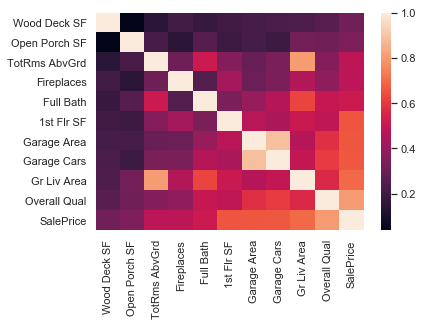

In [11]:
strong_corrs = sorted_corr[sorted_corr > 0.3]
corrmat = train_subset[strong_corrs.index].corr()
sns.heatmap(corrmat)

Based on the correlation matrix heatmap, we can tell that the following pairs of columns are strongly correlated:
* `Gr Liv Area` and `TotRms AbvGrd`
* `Garage Area` and `Garage Cars`

Let's drop the `TotRms AbvGrd` and `Garage Cars`.

In [12]:
final_corr_cols = strong_corrs.drop(['Garage Cars', 'TotRms AbvGrd'])
print(test[final_corr_cols.index].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 1460 to 2929
Data columns (total 9 columns):
Wood Deck SF     1470 non-null int64
Open Porch SF    1470 non-null int64
Fireplaces       1470 non-null int64
Full Bath        1470 non-null int64
1st Flr SF       1470 non-null int64
Garage Area      1469 non-null float64
Gr Liv Area      1470 non-null int64
Overall Qual     1470 non-null int64
SalePrice        1470 non-null int64
dtypes: float64(1), int64(8)
memory usage: 103.4 KB
None


Looks like the test set has one pesky row with a missing value for `Garage Area`. Let's just drop this row for now. 

In [13]:
final_corr_cols = strong_corrs.drop(['Garage Cars', 'TotRms AbvGrd'])
features = final_corr_cols.drop(['SalePrice']).index
target = 'SalePrice'
clean_test = test[final_corr_cols.index].dropna()

# build a lr model
lr.fit(train[features], train['SalePrice'])

train_preds = lr.predict(train[features])
test_preds = lr.predict(clean_test[features])

train_mse = mean_squared_error(train_preds, train[target])
test_mse = mean_squared_error(test_preds, clean_test[target])

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

34173.97629185852
41032.026120197705


The last technique we'll explore is removing features with low variance. When the values in a feature column have low variance, they don't meaningfully contribute to the model's predictive capability. On the extreme end, let's imagine a column with a variance of 0. This would mean that all of the values in that column were exactly the same. This means that the column isn't informative and isn't going to help the model make better predictions.

To make apples to apples comparisons between columns, we need to rescale all of the columns to vary between 0 and 1. Then, we can set a cutoff value for variance and remove features that have less than that variance amount. This is known as **min-max scaling** or as **rescaling**. 

In [14]:
# make a new dataframe with rescaled values
unit_train = (train[features] - train[features].min())/(train[features].max()-train[features].min())
# to confirm min and max are 0.0 and 1.0 respectively
print(unit_train.min())
print(unit_train.max())

# to compare variance
sorted_vars = unit_train.var().sort_values()
print(sorted_vars)

Wood Deck SF     0.0
Open Porch SF    0.0
Fireplaces       0.0
Full Bath        0.0
1st Flr SF       0.0
Garage Area      0.0
Gr Liv Area      0.0
Overall Qual     0.0
dtype: float64
Wood Deck SF     1.0
Open Porch SF    1.0
Fireplaces       1.0
Full Bath        1.0
1st Flr SF       1.0
Garage Area      1.0
Gr Liv Area      1.0
Overall Qual     1.0
dtype: float64
Open Porch SF    0.013938
Full Bath        0.018621
Garage Area      0.020347
Gr Liv Area      0.023078
Overall Qual     0.024496
1st Flr SF       0.025814
Wood Deck SF     0.033064
Fireplaces       0.046589
dtype: float64


Let's set a cutoff variance of 0.015, remove the `Open Porch SF` feature, and train and test a model using the remaining features.

In [22]:
clean_test.head()

,Wood Deck SF,Open Porch SF,Fireplaces,Full Bath,1st Flr SF,Garage Area,Gr Liv Area,Overall Qual,SalePrice
1460,168,116,1,2,1366,725.0,1947,9,274000
1461,182,35,1,2,1786,715.0,1786,8,300000
1462,0,0,1,2,1149,779.0,2290,8,255900
1463,0,63,0,2,884,543.0,1768,7,224900
1464,0,57,1,2,1129,596.0,2327,7,240000


In [23]:
clean_test = test[final_corr_cols.index].dropna()
features = features.drop('Open Porch SF')

lr = LinearRegression()
lr.fit(train[features], train['SalePrice'])

train_predictions = lr.predict(train[features])
test_predictions = lr.predict(clean_test[features])

train_mse = mean_squared_error(train_predictions, train[target])
test_mse = mean_squared_error(test_predictions, clean_test[target])

train_rmse_2 = np.sqrt(train_mse)
test_rmse_2 = np.sqrt(test_mse)

print(train_rmse_2)
print(test_rmse_2)

34372.696707783965
40591.42702437721


We were able to improve the RMSE value to approximately 40591 by removing the `Open Porch SF` feature. This is most likely the furthest we can go without transforming and utilizing the other features in the dataset.

In [27]:
# gradient descent 
def derivative(a1, xi_list, yi_list):
    len_data = len(xi_list)
    error = 0
    for i in range(0, len_data):
        error += xi_list[i]*(a1*xi_list[i] - a1*yi_list[i])
    deriv = 2*error/len_data
    return deriv

def gradient_descent(xi_list, yi_list, max_iterations, alpha, a1_initial):
    a1_list = [a1_initial]
    
    for i in range(0, max_iterations):
        a1 = a1_list[i]
        deriv = derivative(a1, xi_list, yi_list)
        a1_new = a1 - alpha*deriv
        a1_list.append(a1_new)
    return(a1_list)

param_iterations = gradient_descent(train['Gr Liv Area'], train['SalePrice'], 20, .0000003, 150)
final_param = param_iterations[-1]

Now that we've understood how single parameter gradient descent works, let's build some intuition for multi parameter gradient descent:

In [28]:
def a1_derivative(a0, a1, xi_list, yi_list):
    len_data = len(xi_list)
    error = 0
    for i in range(0, len_data):
        error += xi_list[i]*(a0 + a1*xi_list[i] - yi_list[i])
    deriv = 2*error/len_data
    return deriv

def a0_derivative(a0, a1, xi_list, yi_list):
    len_data = len(xi_list)
    error = 0
    for i in range(0, len_data):
        error += a0 + a1*xi_list[i] - yi_list[i]
    deriv = 2*error/len_data
    return deriv

def gradient_descent(xi_list, yi_list, max_iterations, alpha, a1_initial, a0_initial):
    a1_list = [a1_initial]
    a0_list = [a0_initial]

    for i in range(0, max_iterations):
        a1 = a1_list[i]
        a0 = a0_list[i]
        
        a1_deriv = a1_derivative(a0, a1, xi_list, yi_list)
        a0_deriv = a0_derivative(a0, a1, xi_list, yi_list)
        
        a1_new = a1 - alpha*a1_deriv
        a0_new = a0 - alpha*a0_deriv
        
        a1_list.append(a1_new)
        a0_list.append(a0_new)
    return(a0_list, a1_list)

a0_params, a1_params = gradient_descent(train['Gr Liv Area'], train['SalePrice'], 20, .0000003, 150, 1000)
print(a0_params)
print(a1_params)    

[1000, 999.9729797812329, 999.985903701066, 999.980232547139, 999.9832179015052, 999.9821734177915, 999.983004932363, 999.9829631191217, 999.9833278635107, 999.98350334434, 999.9837669324418, 999.9839895042135, 999.9842311701743, 999.9844639472566, 999.9847008623329, 999.9849358510428, 999.9851717365096, 999.9854072044933, 999.985642866808, 999.9858784386378, 999.986114052572]
[150, 105.34801721547944, 126.13471917628125, 116.45794862200977, 120.96274606972909, 118.86564116059868, 119.84189984026605, 119.38742488614261, 119.59899502291616, 119.50050320781361, 119.54635359313434, 119.52500879150305, 119.53494516153384, 119.53031930255781, 119.53247255390217, 119.53146994657168, 119.53193647656232, 119.53171908350993, 119.53182007507831, 119.53177285001942, 119.53179462379771]


Unlike gradient descent, **ordinary least squares** (OLS) estimation provides a clear formula to directly calculate the optimal parameter values that minimize the cost function. 

Let's start by computing OLS estimation to find the best parameters for a model using the following features:

In [29]:
features = ['Wood Deck SF', 'Fireplaces', 'Full Bath', '1st Flr SF', 'Garage Area',
       'Gr Liv Area', 'Overall Qual']

X = train[features]
y = train['SalePrice']

first_term = np.linalg.inv(np.dot(np.transpose(X), X))
second_term = np.dot(np.transpose(X), y)

ols_estimation = np.dot(first_term, second_term)
print(ols_estimation)

[   53.75693376 18232.31375751 -6434.65300989    22.53151963
    86.81522574    28.08976713 11397.64135314]


To understand how linear regression works, we've stuck to using features from the training dataset that contained no missing values and were already in a convenient numeric representation. In this mission, we'll explore how to transform some of the remaining features so we can use them in our model. Broadly, the process of processing and creating new features is known as **feature engineering**.

Amongst the columns that don't contain missing values, some of the common issues include:

 * the column is not numerical (e.g. a zoning code represented using text)
 * the column is numerical but not ordinal (e.g. zip code values)
 * the column is numerical but isn't representative of the type of relationship with the target column (e.g. year values)
 
Let's start by filtering the training set to just the columns containing no missing values.

In [30]:
train_null_counts = train.isnull().sum()

df_no_mv = train[train_null_counts[train_null_counts == 0].index]

In [35]:
print(train['Utilities'].value_counts())

AllPub    1457
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64


Some of the columns in the data frame df_no_mv contain string values. If these columns contain only a limited set of uniuqe values, they're known as **categorical features**. As the name suggests, a categorical feature groups a specific training example into a specific category.

To use these features in our model, we need to transform them into numerical representations. We can convert any column that contains no missing values (or an error will be thrown) to the categorical data type using the `pandas.Series.astype()` method:

In [37]:
train['Utilities'] = train['Utilities'].astype('category')
print(train['Utilities'])

0       AllPub
1       AllPub
2       AllPub
3       AllPub
4       AllPub
5       AllPub
6       AllPub
7       AllPub
8       AllPub
9       AllPub
10      AllPub
11      AllPub
12      AllPub
13      AllPub
14      AllPub
15      AllPub
16      AllPub
17      AllPub
18      AllPub
19      AllPub
20      AllPub
21      AllPub
22      AllPub
23      AllPub
24      AllPub
25      AllPub
26      AllPub
27      AllPub
28      AllPub
29      AllPub
         ...  
1430    AllPub
1431    AllPub
1432    AllPub
1433    AllPub
1434    AllPub
1435    AllPub
1436    AllPub
1437    AllPub
1438    AllPub
1439    AllPub
1440    AllPub
1441    AllPub
1442    AllPub
1443    AllPub
1444    AllPub
1445    AllPub
1446    AllPub
1447    AllPub
1448    AllPub
1449    AllPub
1450    AllPub
1451    AllPub
1452    AllPub
1453    AllPub
1454    AllPub
1455    AllPub
1456    AllPub
1457    AllPub
1458    AllPub
1459    AllPub
Name: Utilities, Length: 1460, dtype: category
Categories (3, object): [AllPub, NoSeW

C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


When a column is converted to the categorical data type, pandas assigns a code to each unique value in the column. Unless we access these values directly, most of the pandas manipulation operations that work for string columns will work for categorical ones as well.

We need to use the `.cat` accessor followed by the `.codes` property to actually access the underlying numerical representation of a column:

In [38]:
train['Utilities'].cat.codes

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
1430    0
1431    0
1432    0
1433    0
1434    0
1435    0
1436    0
1437    0
1438    0
1439    0
1440    0
1441    0
1442    0
1443    0
1444    0
1445    0
1446    0
1447    0
1448    0
1449    0
1450    0
1451    0
1452    0
1453    0
1454    0
1455    0
1456    0
1457    0
1458    0
1459    0
Length: 1460, dtype: int8

Let's convert all of the text columns that contain no missing values into the categorical data type.

In [39]:
text_cols = df_no_mv.select_dtypes(include=['object']).columns

for col in text_cols:
    print(col + ':', len(train[col].unique()))

MS Zoning: 6
Street: 2
Lot Shape: 4
Land Contour: 4
Utilities: 3
Lot Config: 5
Land Slope: 3
Neighborhood: 26
Condition 1: 9
Condition 2: 6
Bldg Type: 5
House Style: 8
Roof Style: 6
Roof Matl: 5
Exterior 1st: 14
Exterior 2nd: 16
Exter Qual: 4
Exter Cond: 5
Foundation: 6
Heating: 6
Heating QC: 4
Central Air: 2
Electrical: 4
Kitchen Qual: 5
Functional: 7
Paved Drive: 3
Sale Type: 9
Sale Condition: 5


In [41]:
for col in text_cols:
    train[col] = train[col].astype('category')
train['Utilities'].value_counts()

C:\Users\vungu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AllPub    1457
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64

When we convert a column to the categorical data type, pandas assigns a number from 0 to n-1 (where n is the number of unique values in a column) for each value. **The drawback with this approach is that one of the assumptions of linear regression is violated here.//==** Linear regression operates under the assumption that the features are linearly correlated with the target column. For a categorical feature, however, there's no actual numerical meaning to the categorical codes that pandas assigned for that column. An increase in the Utilities column from 1 to 2 has no correlation value with the target column, and the categorical codes are instead used for uniqueness and exclusivity (the category associated with 0 is different than the one associated with 1).

The common solution is to use a technique called `dummy coding`. Instead of having a single column with n integer codes, we have **n binary columns**.

Because the original values for the first 4 rows were `AllPub`, in the new scheme, they contain the binary value for true (1) in the `Utilities_AllPub` column and 0 for the other 2 columns.

Pandas thankfully has a convenience function to help us apply this transformation for all of the text columns called `pandas.get_dummies()`.

In [42]:
dummy_cols = pd.DataFrame()
for col in text_cols:
    col_dummies = pd.get_dummies(train[col])
    train = pd.concat([train, col_dummies],1)
    del train[col]

Some of the numerical columns in the data set are also categorical and only have a limited set of unique values. We won't explicitly explore those columns in this mission, but the feature transformation process is the same if the numbers used in those categories have no numerical meaning.

Let's now look at numerical features that aren't categorical, but whose numerical representation needs to be improved. We'll focus on the `Year Remod/Add` and `Year Built` columns:

In [43]:
print(train[['Year Remod/Add', 'Year Built']])

      Year Remod/Add  Year Built
0               1960        1960
1               1961        1961
2               1958        1958
3               1968        1968
4               1998        1997
5               1998        1998
6               2001        2001
7               1992        1992
8               1996        1995
9               1999        1999
10              1994        1993
11              2007        1992
12              1998        1998
13              1990        1990
14              1985        1985
15              2003        2003
16              2005        1988
17              2010        2010
18              1951        1951
19              1988        1978
20              1977        1977
21              1974        1974
22              2000        2000
23              1970        1970
24              2008        1971
25              1968        1968
26              1970        1970
27              1971        1971
28              1999        1999
29        

The two main issues with these features are:

 * Year values aren't representative of how old a house is
 * The Year Remod/Add column doesn't actually provide useful information for a linear regression model
 
The challenge with year values like 1960 and 1961 is that they don't do a good job of capturing how old a house is. For example, a house that was built in 1960 but sold in 1980 was sold in half the time as one built in 1960 and sold in 2000. Instead of the years certain events happened, we want the **difference** between those years. We should create a new column that's the difference between both of these columns.

For this particular piece of information (years until remodeled), this is a sensible approach.

In [44]:
years_until_remodeled = train['Year Remod/Add'] - train['Year Built']

We'll focus on handling columns with missing values. When values are missing in a column, there are two main approaches we can take:

* Remove rows containing missing values for specific columns
 * Pro: Rows containing missing values are removed, leaving only clean data for modeling
 * Con: Entire observations from the training set are removed, which can reduce overall prediction accuracy

* Impute (or replace) missing values using a descriptive statistic from the column
 * Pro: Missing values are replaced with potentially similar estimates, preserving the rest of the observation in the model.
 * Con: Depending on the approach, we may be adding noisy data for the model to learn

Given that we only have 1460 training examples (with ~80 potentially useful features), we don't want to remove any of these rows from the dataset. Let's instead focus on **imputation** techniques.

We'll focus on columns that contain at least 1 missing value but less than 365 missing values (or 25% of the number of rows in the training set). There's no strict threshold, and many people instead use a 50% cutoff (if half the values in a column are missing, it's automatically dropped). Having some domain knowledge can help with determining an acceptable cutoff value.

In [48]:
train = df[0:1460]
test = df[1460:]

train_null_counts = train.isnull().sum()
df_missing_values = train[train_null_counts[(train_null_counts > 0) & (train_null_counts < 584)].index]

print(df_missing_values.isnull().sum())
print(df_missing_values.dtypes)

Lot Frontage      249
Mas Vnr Type       11
Mas Vnr Area       11
Bsmt Qual          40
Bsmt Cond          40
Bsmt Exposure      41
BsmtFin Type 1     40
BsmtFin SF 1        1
BsmtFin Type 2     41
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      1
Bsmt Half Bath      1
Garage Type        74
Garage Yr Blt      75
Garage Finish      75
Garage Qual        75
Garage Cond        75
dtype: int64
Lot Frontage      float64
Mas Vnr Type       object
Mas Vnr Area      float64
Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
BsmtFin Type 1     object
BsmtFin SF 1      float64
BsmtFin Type 2     object
BsmtFin SF 2      float64
Bsmt Unf SF       float64
Total Bsmt SF     float64
Bsmt Full Bath    float64
Bsmt Half Bath    float64
Garage Type        object
Garage Yr Blt     float64
Garage Finish      object
Garage Qual        object
Garage Cond        object
dtype: object


It looks like about half of the columns in `df_missing_values` are string columns (`object` data type), while about half are `float64` columns. For numerical columns with missing values, a common strategy is to compute the mean, median, or mode of each column and replace all missing values in that column with that value.

Because imputation is a common task, pandas contains a `pandas.DataFrame.fillna()` method that we can use for this. If we pass in a value, all of the missing values (NaN) in the data frame are replaced by that value:

In [51]:
# only select float columns
missing_floats = df_missing_values.select_dtypes(include=['float'])

# return a new df
float_cols = missing_floats.fillna(missing_floats.mean())

print(float_cols.isnull().sum())

Lot Frontage      0
Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Yr Blt     0
dtype: int64
